# Football Prediction - Feature Engineering
# Creating features from historical match data

# This notebook creates predictive features from our match data:
# - Team form (last 5 matches)
# - Home/Away performance
# - Head-to-head statistics
# - Goal scoring trends

In [1]:
# %% Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import sys
from dotenv import load_dotenv

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

load_dotenv()
sys.path.append('..')

from database_manager import FootballDatabaseManager

print("✓ Imports successful")

✓ Imports successful


In [2]:
# %% Cell 2: Connect and Load Data
db = FootballDatabaseManager(
    host=os.getenv('DB_HOST'),
    port=int(os.getenv('DB_PORT')),
    database=os.getenv('DB_NAME'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD')
)

with db.get_cursor() as cursor:
    cursor.execute("""
        SELECT 
            m.match_id,
            m.fixture_date,
            m.league_id,
            m.season,
            m.home_team_id,
            m.away_team_id,
            ht.team_name as home_team,
            at.team_name as away_team,
            m.home_goals,
            m.away_goals,
            m.outcome,
            m.outcome_numeric
        FROM matches m
        JOIN teams ht ON m.home_team_id = ht.team_id
        JOIN teams at ON m.away_team_id = at.team_id
        ORDER BY m.fixture_date
    """)
    
    matches_df = pd.DataFrame(cursor.fetchall())

matches_df['fixture_date'] = pd.to_datetime(matches_df['fixture_date'])
print(f"✓ Loaded {len(matches_df)} matches")
matches_df.head()

✓ Connected to PostgreSQL database: football_predictions
✓ Loaded 1085 matches


,match_id,fixture_date,league_id,season,home_team_id,away_team_id,home_team,away_team,home_goals,away_goals,outcome,outcome_numeric
0,94202101108,2021-01-10,94,2020,1008,1009,Maritimo,Moreirense,0,0,D,0
1,94202101105,2021-01-10,94,2020,1005,1007,Famalicao,Guimaraes,1,2,A,2
2,942021011114,2021-01-11,94,2020,1014,1011,Sp Braga,Portimonense,3,0,H,1
3,94202101119,2021-01-11,94,2020,1009,1010,Moreirense,Pacos Ferreira,1,1,D,0
4,942021021012,2021-02-10,94,2020,1012,1010,Porto,Pacos Ferreira,2,1,H,1


In [3]:
# %% Cell 3: Helper Functions

def calculate_points(goals_for, goals_against):
    """Calculate points: 3 for win, 1 for draw, 0 for loss"""
    if goals_for > goals_against:
        return 3
    elif goals_for == goals_against:
        return 1
    else:
        return 0

def get_team_last_n_matches(df, team_id, before_date, n=5, is_home=None):
    """
    Get last N matches for a team before a given date
    
    Args:
        df: matches dataframe
        team_id: team ID to look for
        before_date: only get matches before this date
        n: number of matches to retrieve
        is_home: if True, only home matches; if False, only away; if None, all matches
    """
    if is_home is True:
        team_matches = df[
            (df['home_team_id'] == team_id) & 
            (df['fixture_date'] < before_date)
        ].tail(n)
    elif is_home is False:
        team_matches = df[
            (df['away_team_id'] == team_id) & 
            (df['fixture_date'] < before_date)
        ].tail(n)
    else:
        team_matches = df[
            ((df['home_team_id'] == team_id) | (df['away_team_id'] == team_id)) & 
            (df['fixture_date'] < before_date)
        ].tail(n)
    
    return team_matches

def calculate_team_form(df, team_id, before_date, n=5):
    """
    Calculate team form based on last N matches
    Returns dict with various form metrics
    """
    prev_matches = get_team_last_n_matches(df, team_id, before_date, n)
    
    if len(prev_matches) == 0:
        return {
            'matches_played': 0,
            'points': 0,
            'wins': 0,
            'draws': 0,
            'losses': 0,
            'goals_scored': 0,
            'goals_conceded': 0,
            'avg_goals_scored': 0,
            'avg_goals_conceded': 0,
            'win_rate': 0,
            'points_per_game': 0
        }
    
    points = 0
    wins = 0
    draws = 0
    losses = 0
    goals_scored = 0
    goals_conceded = 0
    
    for _, match in prev_matches.iterrows():
        # Check if team was home or away
        if match['home_team_id'] == team_id:
            gf = match['home_goals']
            ga = match['away_goals']
        else:
            gf = match['away_goals']
            ga = match['home_goals']
        
        goals_scored += gf
        goals_conceded += ga
        
        pts = calculate_points(gf, ga)
        points += pts
        
        if pts == 3:
            wins += 1
        elif pts == 1:
            draws += 1
        else:
            losses += 1
    
    n_matches = len(prev_matches)
    
    return {
        'matches_played': n_matches,
        'points': points,
        'wins': wins,
        'draws': draws,
        'losses': losses,
        'goals_scored': goals_scored,
        'goals_conceded': goals_scored,
        'avg_goals_scored': goals_scored / n_matches,
        'avg_goals_conceded': goals_conceded / n_matches,
        'win_rate': wins / n_matches,
        'points_per_game': points / n_matches
    }

def calculate_h2h(df, home_team_id, away_team_id, before_date, n=5):
    """
    Calculate head-to-head statistics
    Returns dict with H2H metrics from home team's perspective
    """
    h2h_matches = df[
        (((df['home_team_id'] == home_team_id) & (df['away_team_id'] == away_team_id)) |
         ((df['home_team_id'] == away_team_id) & (df['away_team_id'] == home_team_id))) &
        (df['fixture_date'] < before_date)
    ].tail(n)
    
    if len(h2h_matches) == 0:
        return {
            'h2h_matches': 0,
            'h2h_home_wins': 0,
            'h2h_draws': 0,
            'h2h_away_wins': 0,
            'h2h_home_goals_avg': 0,
            'h2h_away_goals_avg': 0
        }
    
    home_wins = 0
    draws = 0
    away_wins = 0
    home_goals_total = 0
    away_goals_total = 0
    
    for _, match in h2h_matches.iterrows():
        # Determine goals from home team's perspective
        if match['home_team_id'] == home_team_id:
            home_goals = match['home_goals']
            away_goals = match['away_goals']
        else:
            home_goals = match['away_goals']
            away_goals = match['home_goals']
        
        home_goals_total += home_goals
        away_goals_total += away_goals
        
        if home_goals > away_goals:
            home_wins += 1
        elif home_goals < away_goals:
            away_wins += 1
        else:
            draws += 1
    
    n_matches = len(h2h_matches)
    
    return {
        'h2h_matches': n_matches,
        'h2h_home_wins': home_wins,
        'h2h_draws': draws,
        'h2h_away_wins': away_wins,
        'h2h_home_goals_avg': home_goals_total / n_matches,
        'h2h_away_goals_avg': away_goals_total / n_matches
    }

print("✓ Helper functions defined")

✓ Helper functions defined


In [4]:
# %% Cell 4: Create Features for Each Match

print("Creating features for each match...")
print("This may take a few minutes...")

features_list = []

for idx, match in matches_df.iterrows():
    if idx % 100 == 0:
        print(f"  Processing match {idx+1}/{len(matches_df)}...")
    
    match_id = match['match_id']
    match_date = match['fixture_date']
    home_team_id = match['home_team_id']
    away_team_id = match['away_team_id']
    
    # Calculate home team form (last 5 matches)
    home_form_5 = calculate_team_form(matches_df, home_team_id, match_date, n=5)
    
    # Calculate away team form (last 5 matches)
    away_form_5 = calculate_team_form(matches_df, away_team_id, match_date, n=5)
    
    # Calculate home team's home performance
    home_prev_home = get_team_last_n_matches(matches_df, home_team_id, match_date, n=5, is_home=True)
    home_home_points = sum([calculate_points(m['home_goals'], m['away_goals']) 
                            for _, m in home_prev_home.iterrows()]) if len(home_prev_home) > 0 else 0
    
    # Calculate away team's away performance
    away_prev_away = get_team_last_n_matches(matches_df, away_team_id, match_date, n=5, is_home=False)
    away_away_points = sum([calculate_points(m['away_goals'], m['home_goals']) 
                           for _, m in away_prev_away.iterrows()]) if len(away_prev_away) > 0 else 0
    
    # Calculate head-to-head
    h2h = calculate_h2h(matches_df, home_team_id, away_team_id, match_date, n=5)
    
    # Compile all features
    features = {
        'match_id': match_id,
        'fixture_date': match_date,
        'league_id': match['league_id'],
        'season': match['season'],
        'home_team_id': home_team_id,
        'away_team_id': away_team_id,
        
        # Target variable
        'outcome': match['outcome'],
        'outcome_numeric': match['outcome_numeric'],
        
        # Home team form features
        'home_form_points': home_form_5['points'],
        'home_form_wins': home_form_5['wins'],
        'home_form_draws': home_form_5['draws'],
        'home_form_losses': home_form_5['losses'],
        'home_form_goals_scored': home_form_5['goals_scored'],
        'home_form_goals_conceded': home_form_5['goals_conceded'],
        'home_form_avg_goals_scored': home_form_5['avg_goals_scored'],
        'home_form_avg_goals_conceded': home_form_5['avg_goals_conceded'],
        'home_form_win_rate': home_form_5['win_rate'],
        'home_form_ppg': home_form_5['points_per_game'],
        
        # Away team form features
        'away_form_points': away_form_5['points'],
        'away_form_wins': away_form_5['wins'],
        'away_form_draws': away_form_5['draws'],
        'away_form_losses': away_form_5['losses'],
        'away_form_goals_scored': away_form_5['goals_scored'],
        'away_form_goals_conceded': away_form_5['goals_conceded'],
        'away_form_avg_goals_scored': away_form_5['avg_goals_scored'],
        'away_form_avg_goals_conceded': away_form_5['avg_goals_conceded'],
        'away_form_win_rate': away_form_5['win_rate'],
        'away_form_ppg': away_form_5['points_per_game'],
        
        # Home/Away specific performance
        'home_home_points_last_5': home_home_points,
        'away_away_points_last_5': away_away_points,
        
        # Head-to-head features
        'h2h_matches': h2h['h2h_matches'],
        'h2h_home_wins': h2h['h2h_home_wins'],
        'h2h_draws': h2h['h2h_draws'],
        'h2h_away_wins': h2h['h2h_away_wins'],
        'h2h_home_goals_avg': h2h['h2h_home_goals_avg'],
        'h2h_away_goals_avg': h2h['h2h_away_goals_avg'],
        
        # Derived features
        'form_points_diff': home_form_5['points'] - away_form_5['points'],
        'form_ppg_diff': home_form_5['points_per_game'] - away_form_5['points_per_game'],
        'form_goals_scored_diff': home_form_5['avg_goals_scored'] - away_form_5['avg_goals_scored'],
        'form_goals_conceded_diff': away_form_5['avg_goals_conceded'] - home_form_5['avg_goals_conceded'],
    }
    
    features_list.append(features)

features_df = pd.DataFrame(features_list)

print(f"\n✓ Created {len(features_df)} feature sets")
print(f"✓ Total features per match: {len(features_df.columns) - 8}")  # Excluding ID and target columns

features_df.head()

Creating features for each match...
This may take a few minutes...
  Processing match 1/1085...
  Processing match 101/1085...
  Processing match 201/1085...
  Processing match 301/1085...
  Processing match 401/1085...
  Processing match 501/1085...
  Processing match 601/1085...
  Processing match 701/1085...
  Processing match 801/1085...
  Processing match 901/1085...
  Processing match 1001/1085...

✓ Created 1085 feature sets
✓ Total features per match: 32


,match_id,fixture_date,league_id,season,home_team_id,away_team_id,outcome,outcome_numeric,home_form_points,home_form_wins,...,h2h_matches,h2h_home_wins,h2h_draws,h2h_away_wins,h2h_home_goals_avg,h2h_away_goals_avg,form_points_diff,form_ppg_diff,form_goals_scored_diff,form_goals_conceded_diff
0,94202101108,2021-01-10,94,2020,1008,1009,D,0,0,0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
1,94202101105,2021-01-10,94,2020,1005,1007,A,2,0,0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
2,942021011114,2021-01-11,94,2020,1014,1011,H,1,0,0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
3,94202101119,2021-01-11,94,2020,1009,1010,D,0,1,0,...,0,0,0,0,0.0,0.0,1,1.0,0.0,0.0
4,942021021012,2021-02-10,94,2020,1012,1010,H,1,0,0,...,0,0,0,0,0.0,0.0,-1,-1.0,-1.0,1.0


In [ ]:
# %% Cell 5: Remove Matches with Insufficient History

# Remove matches where teams don't have enough previous matches
min_matches_required = 3

features_clean = features_df[
    (features_df['home_form_points'].notna()) &
    (features_df['away_form_points'].notna())
].copy()

removed = len(features_df) - len(features_clean)

print(f"Removed {removed} matches with insufficient history")
print(f"Remaining matches: {len(features_clean)}")


In [ ]:
# %% Cell 6: Feature Statistics

print("\n" + "="*60)
print("FEATURE STATISTICS")
print("="*60)

# Select numeric features only
numeric_features = features_clean.select_dtypes(include=[np.number]).columns
numeric_features = [f for f in numeric_features if f not in ['match_id', 'league_id', 'season', 
                                                               'home_team_id', 'away_team_id',
                                                               'outcome_numeric']]

print(f"\nTotal numeric features: {len(numeric_features)}")
print(f"\nSample features:")
for feat in numeric_features[:10]:
    print(f"  - {feat}")

# Check for missing values
missing = features_clean[numeric_features].isnull().sum()
if missing.sum() > 0:
    print(f"\nFeatures with missing values:")
    print(missing[missing > 0])
else:
    print(f"\n✓ No missing values in features")

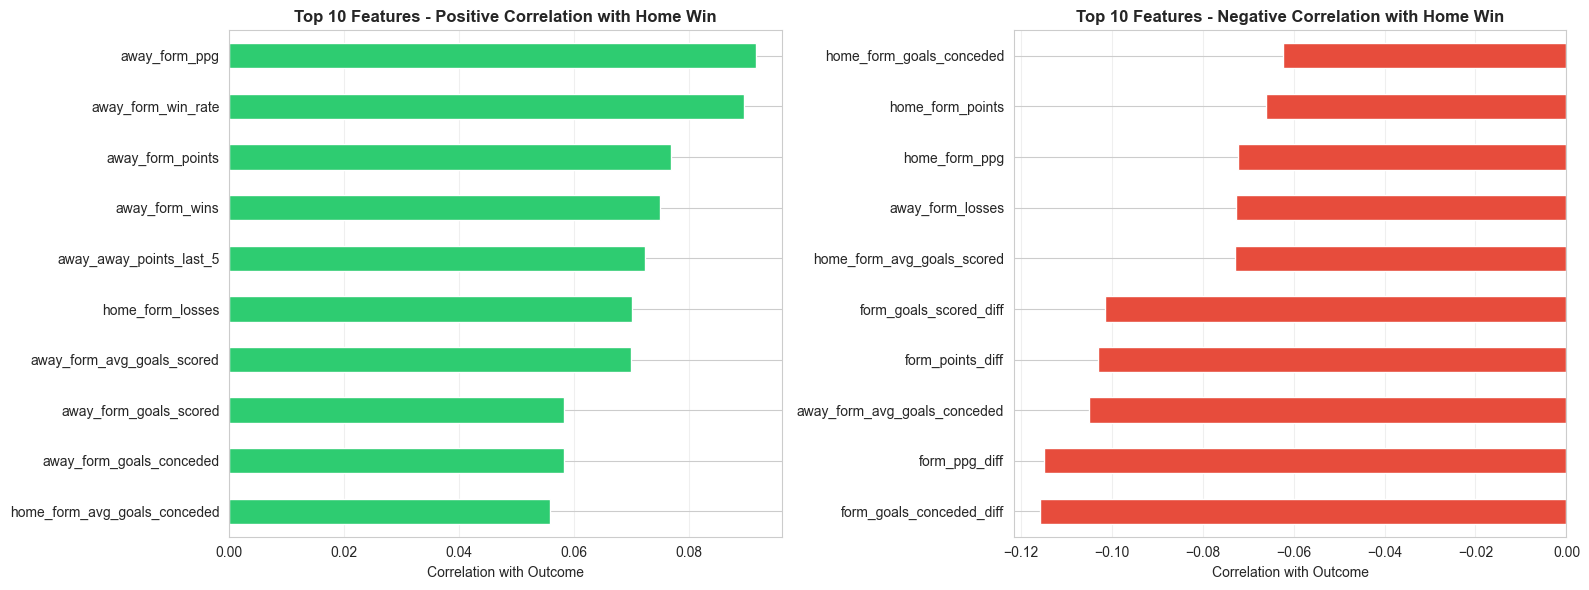


Top 10 Most Correlated Features:
away_form_ppg                   0.091525
away_form_win_rate              0.089591
away_form_points                0.076827
away_form_wins                  0.074872
away_away_points_last_5         0.072355
home_form_losses                0.070104
away_form_avg_goals_scored      0.069913
away_form_goals_scored          0.058294
away_form_goals_conceded        0.058294
home_form_avg_goals_conceded    0.055722
dtype: float64


In [6]:
# %% Cell 7: Feature Correlations with Outcome

# Calculate correlation with outcome
correlations = features_clean[numeric_features].corrwith(features_clean['outcome_numeric']).sort_values(ascending=False)

# Plot top correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Positive correlations (favor home win)
top_positive = correlations.head(10)
top_positive.plot(kind='barh', ax=ax1, color='#2ecc71')
ax1.set_title('Top 10 Features - Positive Correlation with Home Win', fontweight='bold')
ax1.set_xlabel('Correlation with Outcome')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Negative correlations (favor away win/draw)
top_negative = correlations.tail(10)
top_negative.plot(kind='barh', ax=ax2, color='#e74c3c')
ax2.set_title('Top 10 Features - Negative Correlation with Home Win', fontweight='bold')
ax2.set_xlabel('Correlation with Outcome')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Correlated Features:")
print(correlations.head(10))

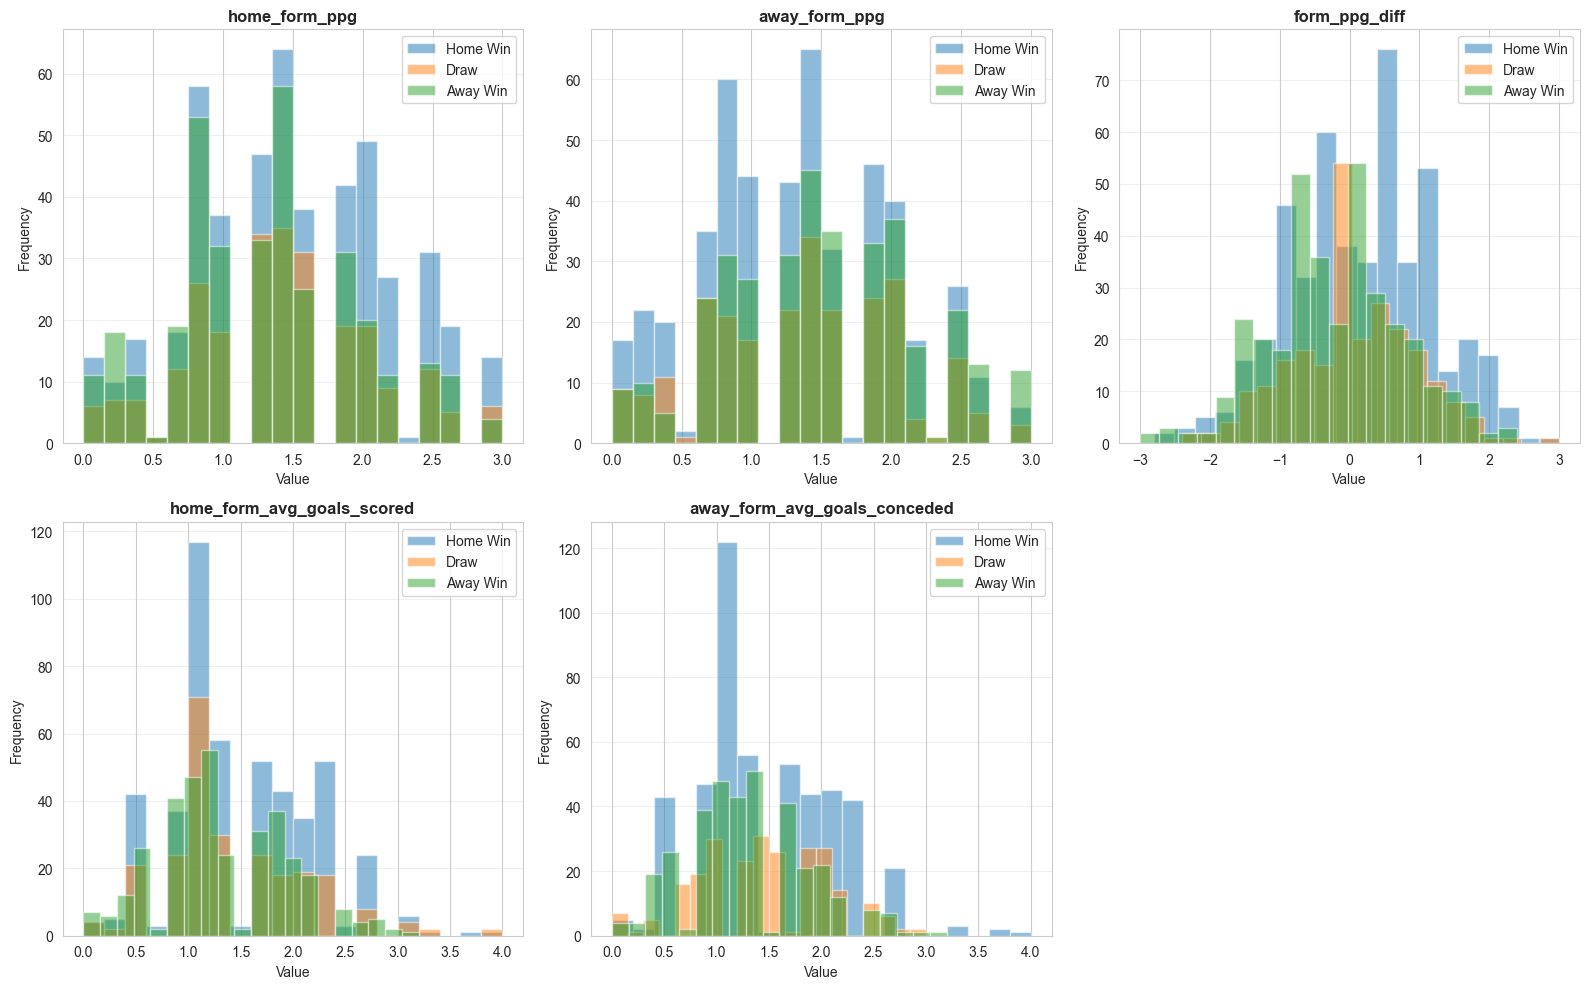

In [7]:
# %% Cell 8: Feature Distributions by Outcome

# Select key features to visualize
key_features = [
    'home_form_ppg',
    'away_form_ppg',
    'form_ppg_diff',
    'home_form_avg_goals_scored',
    'away_form_avg_goals_conceded'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    for outcome in ['H', 'D', 'A']:
        data = features_clean[features_clean['outcome'] == outcome][feature]
        axes[idx].hist(data, alpha=0.5, label=outcome, bins=20)
    
    axes[idx].set_title(f'{feature}', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend(['Home Win', 'Draw', 'Away Win'])
    axes[idx].grid(axis='y', alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# %% Cell 9: Save Processed Features

# Save to CSV
output_path = '../data/processed/features_engineered.csv'
features_clean.to_csv(output_path, index=False)

print(f"\n✓ Saved engineered features to: {output_path}")
print(f"✓ Shape: {features_clean.shape}")
print(f"✓ Features: {len(numeric_features)}")


✓ Saved engineered features to: ../data/processed/features_engineered.csv
✓ Shape: (1085, 40)
✓ Features: 32


In [10]:
# %% Cell 10: Summary

print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"\nTotal matches processed: {len(features_clean)}")
print(f"Total features created: {len(numeric_features)}")
print(f"\nFeature categories:")
print(f"  - Home team form: 10 features")
print(f"  - Away team form: 10 features")
print(f"  - Home/Away specific: 2 features")
print(f"  - Head-to-head: 6 features")
print(f"  - Derived features: 4 features")
print(f"\nData saved to: {output_path}")
print(f"Ready for model training!")


FEATURE ENGINEERING SUMMARY

Total matches processed: 1085
Total features created: 32

Feature categories:
  - Home team form: 10 features
  - Away team form: 10 features
  - Home/Away specific: 2 features
  - Head-to-head: 6 features
  - Derived features: 4 features

Data saved to: ../data/processed/features_engineered.csv
Ready for model training!


In [11]:
# %% Cell 11: Close Database Connection
db.close()
print("\n✓ Feature engineering complete!")

✓ Database connections closed

✓ Feature engineering complete!
